In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

c:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
plt.rcParams["pdf.fonttype"] = 42

In [3]:
exts = ['pdf', 'svg']

In [4]:
palette = {
    '1.5C': pyam.plotting.PYAM_COLORS["AR6-C1"],
    '1.5C-OS': pyam.plotting.PYAM_COLORS["AR6-C2"],
    '2C': pyam.plotting.PYAM_COLORS["AR6-C3"],
}

# Load Data

In [5]:
data_path = pathlib.Path('../data')
paper_prefix = '10.5281_zenodo.10158920_gidden_et_al_2023_ar6_reanalysis'

In [6]:
meta = pd.merge(
    pd.read_csv(data_path / f'{paper_prefix}_meta.csv'),
    pd.read_csv(data_path / 'additional_analysis_metadata.csv'),
    on=['model', 'scenario'], how='inner'
)

# Plot Utilities

In [7]:
meta_variable_templates = [
    'AR6 climate diagnostics|Infilled|Emissions|{gas}', # as reported in AR6
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}|Direct Only', # reanalyzed by OSCAR
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}', # reanalyzed by OSCAR including NGHGI adjustment 
]

data_variable_templates = [
    'AR6 climate diagnostics|Infilled|Emissions|{gas}', # as reported in AR6
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}', # reanalyzed by OSCAR
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas} - Direct and Indirect Fluxes', # reanalyzed by OSCAR including NGHGI adjustment 
]

In [8]:
def figure_data(data, variable_start, gas, name, templates='data'):
    print(name)
    templates = data_variable_templates if templates == 'data' else meta_variable_templates
    cols = [variable_start + template.format(gas=gas) for template in templates]
    headers = ['AR6 Statistics', 'Pathways with OSCAR Direct Effects', 'Pathways with OSCAR Direct & Indirect Effects']
    for col in cols:
        if not col in data:
            raise ValueError(f'{col} not in data columns')
    ret = (
        data
        .query("Category in ['C1', 'C2', 'C3']")
        .replace({'Category': {'C1': '1.5C', 'C2': '1.5C-OS', 'C3': '2C'}})
        .rename(columns={c: h for c, h in zip(cols, headers)})
        [headers + ['Category']]
    )
    ret = (
        ret
        .dropna()
        .sort_values(by='AR6 Statistics', ascending=True)
        .reset_index(drop=True)
        .reset_index()
    )
    return ret

In [9]:
def scatter_compare(
    data, right='Pathways with OSCAR Direct Effects', left="Pathways with OSCAR Direct & Indirect Effects",
    legend={},
):
    fig, ax = plt.subplots(figsize=(8, 8))
    hue = 'Category'
    sns.scatterplot(
        data=data, 
        x=right, y="index", hue=hue, palette=palette,
        #label=right,
        marker='o', s=75, edgecolor='white', linewidths=0.05, 
        ax=ax, 
    )
    sns.scatterplot(
        data=data, 
        x=left, y="index", hue=hue, palette=palette,
        #label=left,
        marker='^', s=75,  edgecolor='white', linewidths=0.05, 
        ax=ax,
    )
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    idx = 2 + len(data[hue].unique())
    if legend != {}:
        idxs = [1, 3, 2]#, 0, 5]
        handles = [h[i] for i in idxs]
        labels = [l[i] for i in idxs]
        ax.legend(handles, labels, **legend)
    else:
        ax.legend().remove()

    return fig, ax

# Cumulative CO2

Carbon Budget from 2020


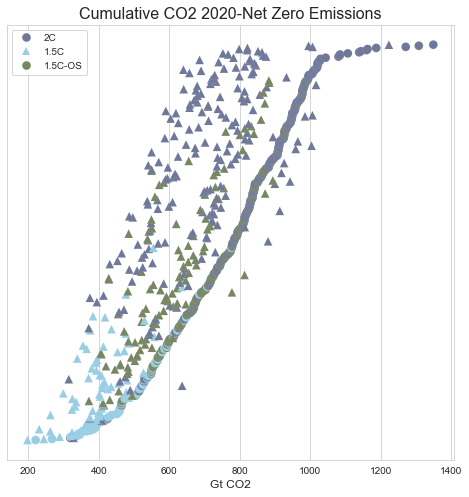

In [10]:
data = figure_data(meta, 'Carbon Budget for ', 'CO2', 'Carbon Budget from 2020')
fig, ax = scatter_compare(
    data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects', 
    legend={'loc': 'best'}
)
ax.set_title('Cumulative CO2 2020-Net Zero Emissions', fontsize=16)
ax.set_xlabel('Gt CO2', fontsize=12)
for ext in exts:
    fig.savefig(f'./files/fig3a1.{ext}', dpi=1200, bbox_inches='tight')

C:\Users\gidden\AppData\Local\Temp\ipykernel_2980\1456854442.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


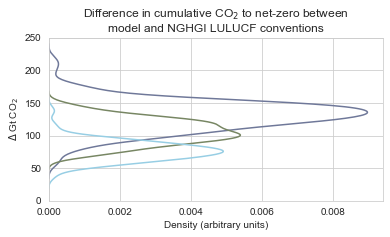

In [11]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, hue_order=list(palette.keys()), multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((0, 250))
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# changes made for final figure
ax.set_title('Difference in cumulative CO$_2$ to net-zero between\nmodel and NGHGI LULUCF conventions')
ax.set_ylabel('$\Delta$ Gt CO$_2$')
ax.legend().remove()

for ext in exts:
    fig.savefig(f'./files/fig3_c.{ext}', dpi=1200, bbox_inches='tight')

In [12]:
data.groupby('Category')[label].quantile((0.05, 0.25, 0.5, 0.75, 0.95))

Category      
1.5C      0.05     54.410584
          0.25     65.445927
          0.50     74.739290
          0.75     84.773782
          0.95     95.916680
1.5C-OS   0.05     73.615450
          0.25     91.901327
          0.50    104.439078
          0.75    119.932519
          0.95    134.491503
2C        0.05     92.927003
          0.25    115.116773
          0.50    131.226768
          0.75    145.589257
          0.95    166.528725
Name: Difference Between Direct and Indirect Fluxes, dtype: float64

# Net-zero Year

Net-zero CO2 Year


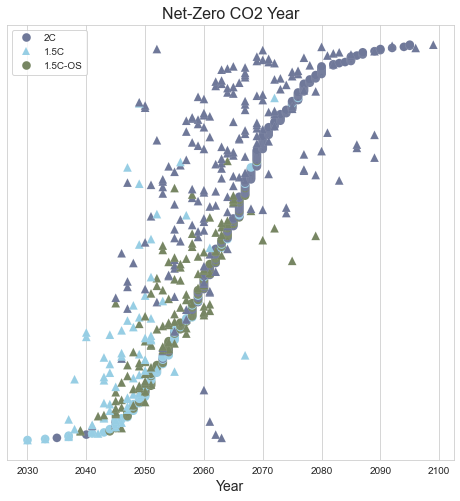

In [13]:
data = figure_data(meta, 'Interpolated Net-Zero Year for ', 'CO2', 'Net-zero CO2 Year', templates='meta')
fig, ax = scatter_compare(
    data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects', 
    legend={'loc': 'best'},
)
ax.set_title('Net-Zero CO2 Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
for ext in exts:
    fig.savefig(f'./files/fig3b1.{ext}', dpi=1200, bbox_inches='tight')

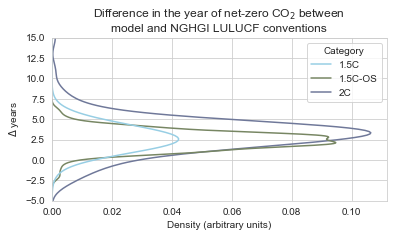

In [14]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, hue_order=list(palette.keys()), multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((-5, 15))

# changes made for final figure
ax.set_title('Difference in the year of net-zero CO$_2$ between\nmodel and NGHGI LULUCF conventions')
ax.set_ylabel('$\Delta$ years')

for ext in exts:
    fig.savefig(f'./files/fig3_a.{ext}', dpi=1200, bbox_inches='tight')

In [15]:
data.groupby('Category')[label].quantile((0.05, 0.25, 0.5, 0.75, 0.95))

Category      
1.5C      0.05    1.0
          0.25    2.0
          0.50    3.0
          0.75    3.0
          0.95    5.0
1.5C-OS   0.05    1.0
          0.25    2.0
          0.50    2.0
          0.75    3.0
          0.95    4.0
2C        0.05   -1.0
          0.25    2.0
          0.50    3.0
          0.75    4.0
          0.95    6.6
Name: Difference Between Direct and Indirect Fluxes, dtype: float64

# Emission reduction percentage between 2020 and 2030

This value is computed in `../data/make_additional_metadata.ipynb` and is defined as 

$$R_{model} = 1 - \frac{E^{CO2}_{model, 2030}}{E^{CO2}_{model, 2020}}$$
$$R_{NGHGI} = 1 - \frac{E^{CO2}_{NGHGI, 2030}}{E^{CO2}_{NGHGI, 2020}}$$

$$metric = R_{model} - R_{NGHGI}$$

2020-2030 Emission Reductions


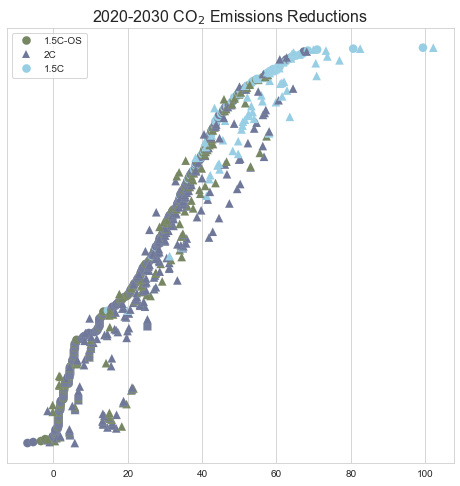

In [16]:
data = figure_data(meta, '2030 Emission Reductions for ', 'CO2', '2020-2030 Emission Reductions')
fig, ax = scatter_compare(
    data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects', 
    legend={'loc': 'best'},
)
ax.set_title('2020-2030 CO$_2$ Emissions Reductions', fontsize=16)
ax.set_ylabel('$\Delta$ %')
for ext in exts:
    fig.savefig(f'./files/fig3c1.{ext}', dpi=1200, bbox_inches='tight')

C:\Users\gidden\AppData\Local\Temp\ipykernel_2980\3523225686.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


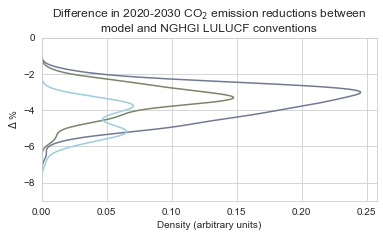

In [17]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, hue_order=list(palette.keys()), multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((-9, 0))

# changes made for final figure
ax.set_title('Difference in 2020-2030 CO$_2$ emission reductions between\nmodel and NGHGI LULUCF conventions')
ax.set_ylabel('$\Delta$ %')
ax.legend().remove()


for ext in exts:
    fig.savefig(f'./files/fig3_b.{ext}', dpi=1200, bbox_inches='tight')

In [18]:
data.groupby('Category')[label].quantile((0.05, 0.25, 0.5, 0.75, 0.95))

Category      
1.5C      0.05   -5.867797
          0.25   -5.181305
          0.50   -4.468155
          0.75   -3.762012
          0.95   -3.412507
1.5C-OS   0.05   -4.692446
          0.25   -3.861042
          0.50   -3.340600
          0.75   -3.009684
          0.95   -2.451136
2C        0.05   -5.069553
          0.25   -4.221677
          0.50   -3.490115
          0.75   -2.890608
          0.95   -2.474687
Name: Difference Between Direct and Indirect Fluxes, dtype: float64